<a href="https://colab.research.google.com/github/liavaldetaro/RadarDataset/blob/main/RadarDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Radar dataset**

In this notebook, we will explore a radar dataset from Kaggle: https://www.kaggle.com/datasets/iroldan/real-doppler-raddar-database


> The radar used to capture the data is a ubiquitous or persistent radar system developed by the Microwave and Radar Group from the UPM called RAD-DAR (Digital Array Receiver). The radar uses a frequency-modulated continuous wave (FMCW) on a frequency band centered at 8.75 GHz with a maximum bandwidth of 500 MHz.

The data contains **labelled** video radar data from cars, people and drones. Let's try to see if we can classify it!



In [34]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections.abc import Iterator
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from keras.callbacks import EarlyStopping
import kagglehub
from sklearn.model_selection import train_test_split

In [3]:

# Let's start by downloading the dataset into our notebook:
path = kagglehub.dataset_download("iroldan/real-doppler-raddar-database")

# Let's print the path to where the data is saved to:
print("Path to dataset files:", path)

100%|██████████| 63.6M/63.6M [00:00<00:00, 185MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iroldan/real-doppler-raddar-database/versions/2


## **Data analysis**

Perfect! Our data is loaded into the .cache folder. Let's start by taking a look at what the data looks like.

In [4]:
# Let's see what is in our dataset

print(os.listdir(path))   # listing the subdirectories
print(os.listdir(path + '/data/Cars/15-42'))

['Cars', 'People', 'Drones', 'data']
['159.csv', '145.csv', '014.csv', '161.csv', '114.csv', '117.csv', '177.csv', '024.csv', '127.csv', '008.csv', '031.csv', '172.csv', '079.csv', '148.csv', '053.csv', '022.csv', '166.csv', '185.csv', '151.csv', '162.csv', '057.csv', '110.csv', '062.csv', '030.csv', '153.csv', '064.csv', '167.csv', '065.csv', '135.csv', '126.csv', '072.csv', '131.csv', '140.csv', '012.csv', '134.csv', '103.csv', '099.csv', '035.csv', '094.csv', '184.csv', '119.csv', '092.csv', '154.csv', '138.csv', '011.csv', '082.csv', '130.csv', '123.csv', '168.csv', '112.csv', '096.csv', '163.csv', '105.csv', '088.csv', '152.csv', '029.csv', '021.csv', '002.csv', '005.csv', '136.csv', '048.csv', '017.csv', '104.csv', '070.csv', '142.csv', '038.csv', '078.csv', '118.csv', '086.csv', '125.csv', '128.csv', '068.csv', '087.csv', '001.csv', '150.csv', '077.csv', '007.csv', '003.csv', '052.csv', '066.csv', '054.csv', '013.csv', '028.csv', '097.csv', '033.csv', '178.csv', '063.csv', '141.

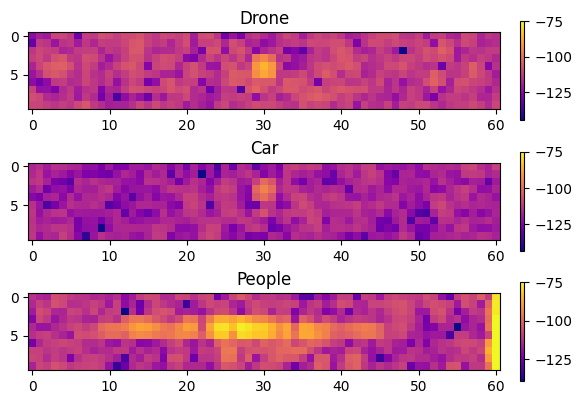

In [5]:
# Let's open an image from each dataset

drone_image = pd.read_csv(
    path + "/Drones/15-42/159.csv"
)

car_image = pd.read_csv(
    path + "/Cars/15-42/159.csv"
)

people_image = pd.read_csv(
    path + "/People/16-06/014.csv"
)


# We can now plot the images
fig, ax = plt.subplots(3, 1)
plt1 = ax[0].imshow(drone_image, cmap='plasma', vmax=-75)
plt2 = ax[1].imshow(car_image, cmap='plasma', vmax=-75)
plt3 = ax[2].imshow(people_image, cmap='plasma', vmax=-75)
ax[0].set_title("Drone")
ax[1].set_title("Car")
ax[2].set_title("People")
plt.colorbar(plt1, ax=ax[0], fraction=0.01, pad=0.04)
plt.colorbar(plt2, ax=ax[1], fraction=0.01, pad=0.04)
plt.colorbar(plt3, ax=ax[2], fraction=0.01, pad=0.04)
plt.show()


The images don't really look that different to the human eye - let's hope our model can do a better job at classifying them :)

### **Data import and processing**

Now that we are a bit more familiar with the data, we can start **preparing it** to feed into our AI model.
There are a couple of steps to this preparation:

1.  Load in the images and corresponding labels (if it is a car, a drone or a person)
2.  Normalize our data - meaning that we change the values so that all of the pixels are between 0 and 1 - this makes it easier for our AI model.
3. Split our data into a training set (which we give to the model) and a test set (which the model doesn't get to see - we use this set to test how good our model is).


To keep our code organized, let's put these functionalities into **python functions**. *Don't worry too much about this part of the code* - the fun AI *training* comes later :)



In [20]:

def load_all_frames(folder_path: str) -> list:
  """Load all CSVs from a folder in order."""
  frames = []
  files = sorted(
      [f for f in os.listdir(folder_path) if f.endswith(".csv")],
      key=lambda x: int(x.split('_')[-1].split('.')[0])
  )
  for file in files:
      file_path = os.path.join(folder_path, file)
      df = pd.read_csv(file_path, header=None).values
      frames.append(df)

  return frames


def prepare_split_data(
    dataset_path:str,
    categories: dict,
    test_size: float,
    random_seed: int,
    stack_size: int
    ) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """Crawls through our data folder, normalizes all images and returns our
    split dataset."""

    X = []  # radar data
    y = []  # data labels (Cars/Drones/People)

    # Let's crawl through the categories (Cars, Drones and People) and go through
    # their respective folders
    for category, label in categories_labels.items():
      # path to a given category (Cars/Drones/People)
      category_path = os.path.join(dataset_path, category)
      for root, _, _ in os.walk(category_path):
        # loading all video frames for each specific sample
        all_frames = load_all_frames(folder_path=root)

        for i in range(len(all_frames) - stack_size + 1):
          stacked_data = np.stack(all_frames[i:i+stack_size], axis=-1)
          X.append(stacked_data) # (11, 61, stack_size)
          y.append(label)        # data labels

      print(f"Finished loading {category}")

    # Now we normalize our data
    X = np.array(X)
    print(f"Dataset shape: {X.shape}")

    mean = np.mean(X, axis=(0, 1, 2))
    std = np.std(X, axis=(0, 1, 2))

    X = (X - mean) / std

    # Let's also change our labels in a numpy array
    y = np.array(y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_seed
    )

    return X_train, X_test, y_train, y_test


Now that we made our data import function, we can finally start the fun part!

First, we import our data:

In [21]:
# We know from the data that our data can either a car, a drone or a person
categories_labels = {"Cars": 0, "Drones": 1, "People": 2}


X_train, X_test, y_train, y_test = prepare_split_data(
    dataset_path=path,
    categories=categories_labels,
    test_size=0.2,
    random_seed=2387,
    stack_size=3
    )

Cars
Drones
People
(17325, 11, 61, 3)


# **Defining the model**

Now that our data is imported, we can design a model to train it with.

We will use a Convolutional Neural Network (https://en.wikipedia.org/wiki/Convolutional_neural_network), since it usually works well for image data.

Should try to alter the architecture if you want! For example, you can try to change:

*   The **number and size of the layers**
*   The **activation type** of the layers
*   The **batch size**
*   The number of **epochs**


How do the changes affect the model performance?



In [23]:
def define_cnn_model(input_shape: np.array) -> tf.Keras.model:
  model = tf.keras.Sequential(
      [
          tf.keras.layers.Input(shape=input_shape),
          # Convolutional 2D layer with Relu activation
          tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
          # We now need to flatten our input to pass it into the dense layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(3, activation="softmax"),
      ]
  )

  return model

We can now pass our data into the model

In [30]:
input_shape = X_train.shape[1:]

model = define_cnn_model(input_shape=input_shape)

# Print a model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 9, 59, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     2,175,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,186,915 (8.34 MB)

 Trainable params: 2,186,915 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1)

Epoch 1/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8312 - loss: 0.3923 - val_accuracy: 0.9654 - val_loss: 0.1207
Epoch 2/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9787 - loss: 0.0665 - val_accuracy: 0.9605 - val_loss: 0.0985
Epoch 3/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9909 - loss: 0.0334 - val_accuracy: 0.9778 - val_loss: 0.0678
Epoch 4/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9956 - loss: 0.0128 - val_accuracy: 0.9769 - val_loss: 0.0737
Epoch 5/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9795 - val_loss: 0.0843
Epoch 6/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9952 - loss: 0.0164 - val_accuracy: 0.9374 - val_loss: 0.2823
Epoch 7/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9907 - loss: 0.0255 - val_accuracy: 0.9752 - val_loss: 0.0915
Epoch 8/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accu

Nice! Let's plot the accuracy and loss of our trained model

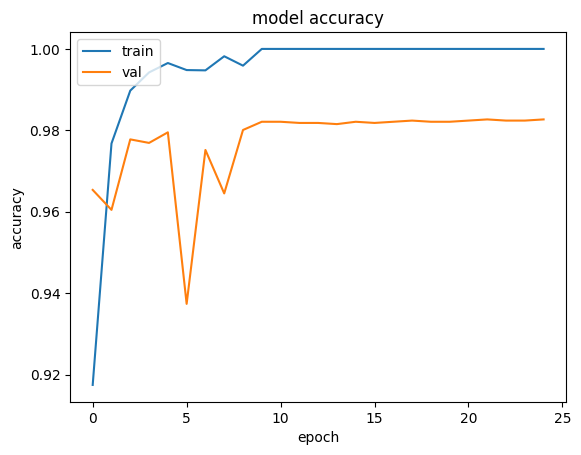

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

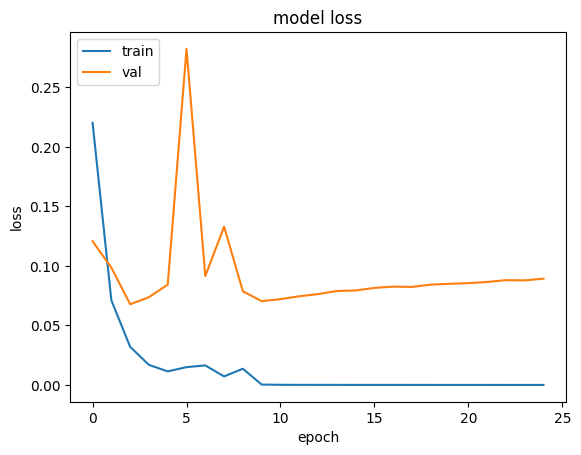

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()